**Import libraries**


In [ ]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

**Define the tickers**

In [ ]:
# Define the stocks to be fetched
symbols = ['AAPL', 'MSFT', 'GOOGL', 'META', 'JFU']

# Fetch stock data from Yahoo Finance
data = yf.download(symbols,'2020-01-01','2023-09-01')

[*********************100%%**********************]  5 of 5 completed


In [ ]:
print(data.head())

            Adj Close                                                Close  \
                 AAPL      GOOGL    JFU        META        MSFT       AAPL   
Date                                                                         
2020-01-02  73.249023  68.433998  190.0  209.779999  155.093674  75.087502   
2020-01-03  72.536896  68.075996  190.0  208.669998  153.162460  74.357498   
2020-01-06  73.114883  69.890503  190.0  212.600006  153.558380  74.949997   
2020-01-07  72.771034  69.755501  190.0  213.059998  152.158279  74.597504   
2020-01-08  73.941658  70.251999  187.0  215.220001  154.581924  75.797501   

                                                      ...       Open  \
                GOOGL    JFU        META        MSFT  ...       AAPL   
Date                                                  ...              
2020-01-02  68.433998  190.0  209.779999  160.619995  ...  74.059998   
2020-01-03  68.075996  190.0  208.669998  158.619995  ...  74.287498   
2020-01-06  69.

**Moving averages and Relative Strength Index**

In [ ]:
# Calculate moving averages and RSI for each stock symbol
for symbol in symbols:
    # Calculate 14-day RSI
    delta = data['Close'][symbol].diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    average_gain = up.rolling(window=14).mean()
    average_loss = abs(down.rolling(window=14).mean())
    rs = average_gain / average_loss
    data[symbol+'_RSI'] = 100 - (100 / (1 + rs))

    # Calculate 50-day moving average
    data[symbol+'_MA50'] = data['Close'][symbol].rolling(window=50).mean()

    # Calculate 200-day moving average
    data[symbol+'_MA200'] = data['Close'][symbol].rolling(window=200).mean()

In [ ]:
# Predict for the next 'n' days using linear regression, decision tree regressor, and random forest regressor
forecast_out = 30

# Create another column shifted 'n' units up for each stock symbol
for symbol in symbols:
    data[symbol+'_Prediction'] = data['Close'][symbol].shift(-forecast_out)


**Training Models**

In [ ]:
# Create the independent and dependent data sets for each stock symbol and train models
for symbol in symbols:
    X = np.array(data.drop([symbol+'_Prediction'], 1))[:-forecast_out]
    y = np.array(data[symbol+'_Prediction'].dropna())

    # Split the data into 80% training and 20% testing
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Standardize the features for better performance using StandardScaler
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # Fill NaN values with 0 because PCA contains NaN values, which causes errors
    x_train_scaled = np.nan_to_num(x_train_scaled)
    x_test_scaled = np.nan_to_num(x_test_scaled)

    # Apply PCA for dimensionality reduction
    #https://www.geeksforgeeks.org/dimensionality-reduction/
    pca = PCA(n_components=2)
    x_train_pca = pca.fit_transform(x_train_scaled)
    x_test_pca = pca.transform(x_test_scaled)

    #Linear Regression Model w/ PCA transformed data
    lr = LinearRegression()
    lr.fit(x_train_pca, y_train)

    #Decision Tree Regressor Model w/ and PCA transformed data
    tree = DecisionTreeRegressor()
    tree.fit(x_train_pca, y_train)

    #Random Forest Regressor Model w/ PCA transformed data
    forest = RandomForestRegressor()
    forest.fit(x_train_pca, y_train)

    #Test the models
    lr_confidence = lr.score(x_test_pca, y_test)
    tree_confidence = tree.score(x_test_pca, y_test)
    forest_confidence = forest.score(x_test_pca, y_test)

    print(symbol + " Linear Regression Confidence: ", lr_confidence)
    print(symbol + " Decision Tree Confidence: ", tree_confidence)
    print(symbol + " Random Forest Confidence: ", forest_confidence)


#.iloc is not working

<ipython-input-59-b5213fe9e4fe>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = np.array(data.drop([symbol+'_Prediction'], 1))[:-forecast_out]


AAPL Linear Regression Confidence:  0.8693749526815797
AAPL Decision Tree Confidence:  0.9081605516537108
AAPL Random Forest Confidence:  0.9468460793945255


<ipython-input-59-b5213fe9e4fe>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = np.array(data.drop([symbol+'_Prediction'], 1))[:-forecast_out]


MSFT Linear Regression Confidence:  0.8035098620081532
MSFT Decision Tree Confidence:  0.8417873573839362
MSFT Random Forest Confidence:  0.9058770578190273


<ipython-input-59-b5213fe9e4fe>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = np.array(data.drop([symbol+'_Prediction'], 1))[:-forecast_out]


GOOGL Linear Regression Confidence:  0.8837169010119778
GOOGL Decision Tree Confidence:  0.9285290838698419
GOOGL Random Forest Confidence:  0.9503598628042024


<ipython-input-59-b5213fe9e4fe>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = np.array(data.drop([symbol+'_Prediction'], 1))[:-forecast_out]


META Linear Regression Confidence:  0.7496966470619988
META Decision Tree Confidence:  0.8259379697861178
META Random Forest Confidence:  0.888153590092148


<ipython-input-59-b5213fe9e4fe>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = np.array(data.drop([symbol+'_Prediction'], 1))[:-forecast_out]


JFU Linear Regression Confidence:  0.6217064867191909
JFU Decision Tree Confidence:  0.9017686032831084
JFU Random Forest Confidence:  0.8934490293521452


**Correlation**

In [ ]:
# Correlation Analysis
correlation_matrix = data.corr()
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                       Adj Close                                          \
                            AAPL     GOOGL       JFU      META      MSFT   
Adj Close        AAPL   1.000000  0.808847 -0.812810  0.181220  0.934111   
                 GOOGL  0.808847  1.000000 -0.555156  0.504299  0.910637   
                 JFU   -0.812810 -0.555156  1.000000 -0.074040 -0.683986   
                 META   0.181220  0.504299 -0.074040  1.000000  0.389772   
                 MSFT   0.934111  0.910637 -0.683986  0.389772  1.000000   
Close            AAPL   0.999870  0.813587 -0.813391  0.191361  0.934948   
                 GOOGL  0.808847  1.000000 -0.555156  0.504299  0.910637   
                 JFU   -0.812810 -0.555156  1.000000 -0.074040 -0.683986   
                 META   0.181220  0.504299 -0.074040  1.000000  0.389772   
                 MSFT   0.927045  0.918937 -0.676471  0.412579  0.999452   
High             AAPL   0.998769  0.810231 -0.816160  0.184809  0.93

**Plot correlation matrix with specified threshold**

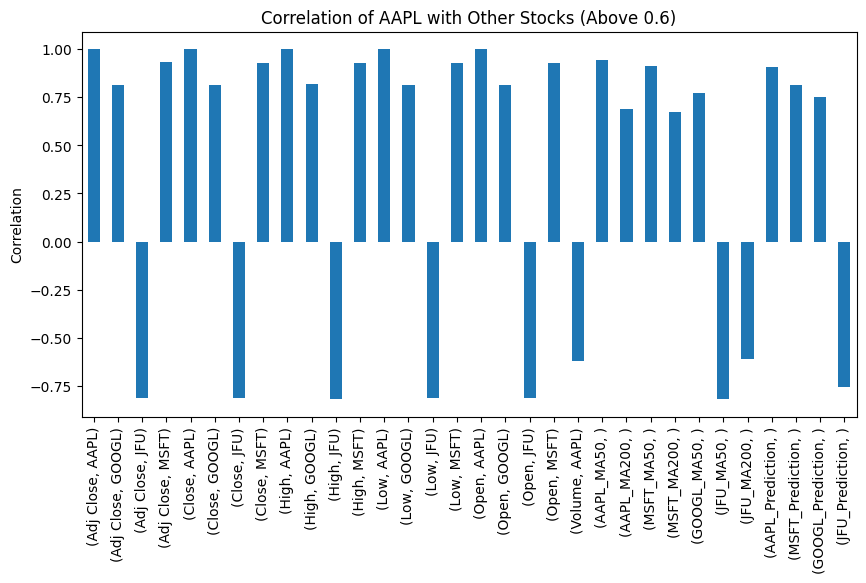

In [ ]:
# Filter correlations for 'AAPL' above a threshold
threshold = 0.6
aapl_correlations = correlation_matrix['Close']['AAPL'][correlation_matrix['Close']['AAPL'].abs() > threshold]

# Plot 'AAPL' correlations
plt.figure(figsize=(10, 5))
aapl_correlations.plot(kind='bar')
plt.title('Correlation of AAPL with Other Stocks (Above 0.6)')
plt.ylabel('Correlation')
plt.show()

**Benchmarking performance agaisnt S&P500**

In [ ]:
# Performance Measurement against S&P 500 Index
benchmark_data = yf.download('SPY','2020-01-01','2023-09-01')['Close']
for symbol in symbols:
   correlation_with_benchmark = data['Close'][symbol].corr(benchmark_data)
   print(symbol + " Correlation with S&P 500: ", correlation_with_benchmark)


[*********************100%%**********************]  1 of 1 completed
AAPL Correlation with S&P 500:  0.8900998247068898
MSFT Correlation with S&P 500:  0.9329114322662561
GOOGL Correlation with S&P 500:  0.95062462020499
META Correlation with S&P 500:  0.44587757367253394
JFU Correlation with S&P 500:  -0.6723668544261696


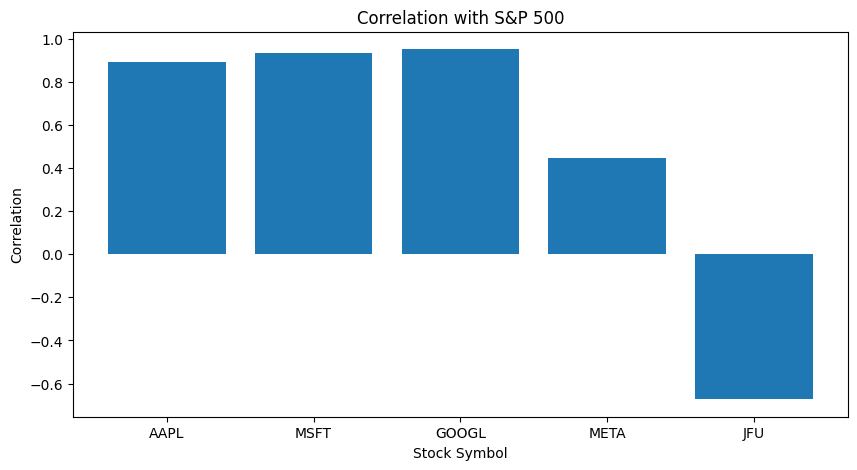

In [ ]:
# Performance measurement
benchmark_corr = [data['Close'][symbol].corr(benchmark_data) for symbol in symbols]
plt.figure(figsize=(10, 5))
plt.bar(symbols, benchmark_corr)
plt.title('Correlation with S&P 500')
plt.xlabel('Stock Symbol')
plt.ylabel('Correlation')
plt.show()

**Risk Analysis**

In [ ]:
# Risk Analysis
for symbol in symbols:
   daily_returns = data['Close'][symbol].pct_change().dropna()
   risk_measure_std_deviation = daily_returns.std()
   print(symbol + " Risk Measure (Standard Deviation of Daily Returns): ", risk_measure_std_deviation)


AAPL Risk Measure (Standard Deviation of Daily Returns):  0.021819554790903452
MSFT Risk Measure (Standard Deviation of Daily Returns):  0.021118552747592577
GOOGL Risk Measure (Standard Deviation of Daily Returns):  0.021448103080327605
META Risk Measure (Standard Deviation of Daily Returns):  0.030356263394661093
JFU Risk Measure (Standard Deviation of Daily Returns):  0.07520947731438413


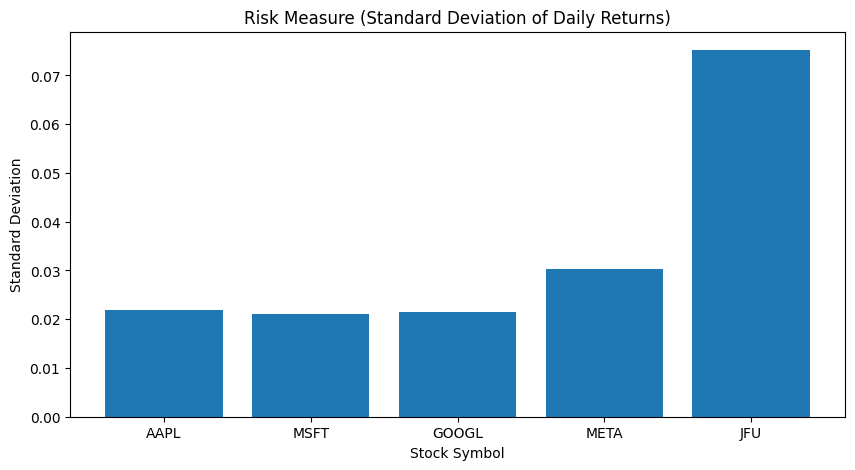

In [ ]:
# Risk measurement
risk_measure_std_deviation = [data['Close'][symbol].pct_change().dropna().std() for symbol in symbols]
plt.figure(figsize=(10, 5))
plt.bar(symbols, risk_measure_std_deviation)
plt.title('Risk Measure (Standard Deviation of Daily Returns)')
plt.xlabel('Stock Symbol')
plt.ylabel('Standard Deviation')
plt.show()

**Volatility measure (need to update metrics)**

In [ ]:
# Calculate daily returns and volatility for each stock symbol
for symbol in symbols:
    # Calculate daily returns
    data[symbol, 'Return'] = data['Close'][symbol].pct_change()

    # Calculate volatility as the standard deviation of returns
    volatility = np.std(data[symbol, 'Return'])

    # Assess volatility
    if volatility < 0.01:
        print(symbol + " is not volatile.")
    elif volatility < 0.02:
        print(symbol + " is moderately volatile.")
    else:
        print(symbol + " is very volatile.")

AAPL is very volatile.
MSFT is very volatile.
GOOGL is very volatile.
META is very volatile.
JFU is very volatile.


**Summary and data visualization**

In [ ]:
# Summary statistics
for symbol in symbols:
    print(data[symbol].describe())

           Return
count  922.000000
mean     0.001233
std      0.021820
min     -0.128647
25%     -0.009473
50%      0.000776
75%      0.013371
max      0.119808
           Return
count  922.000000
mean     0.000997
std      0.021119
min     -0.147390
25%     -0.009659
50%      0.000642
75%      0.012283
max      0.142169
           Return
count  922.000000
mean     0.000976
std      0.021448
min     -0.116341
25%     -0.009595
50%      0.001072
75%      0.012120
max      0.092412
           Return
count  922.000000
mean     0.000843
std      0.030356
min     -0.263901
25%     -0.012657
50%      0.000683
75%      0.015070
max      0.232824
           Return
count  922.000000
mean    -0.001938
std      0.075209
min     -0.338109
25%     -0.038044
50%     -0.004408
75%      0.025286
max      0.836842


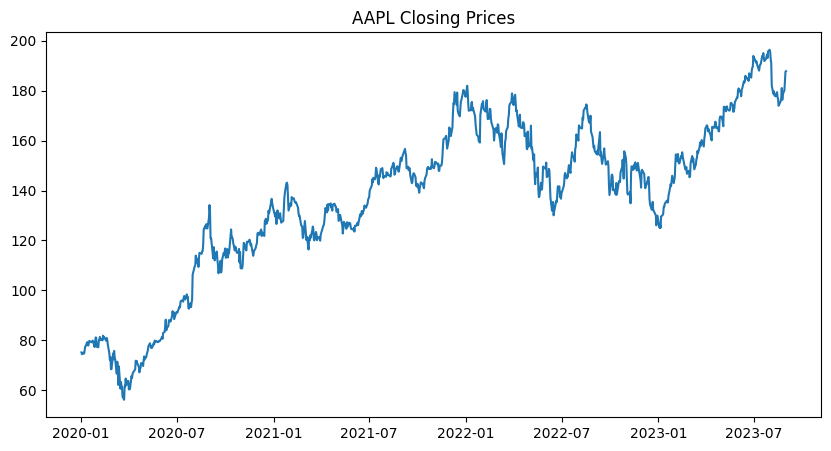

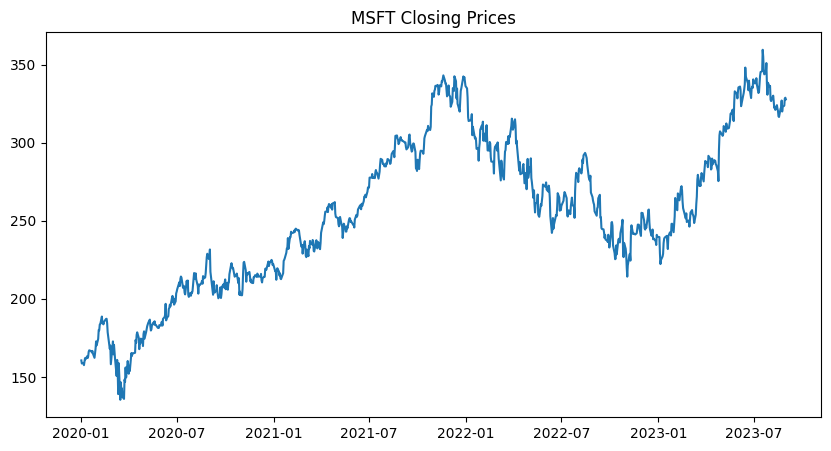

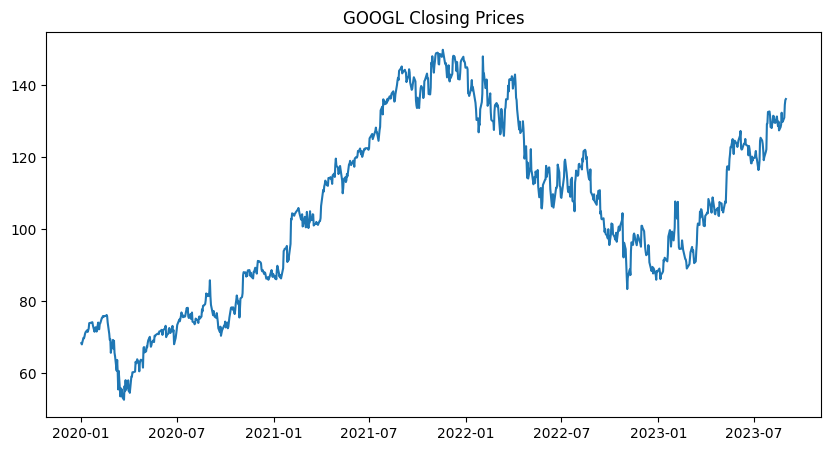

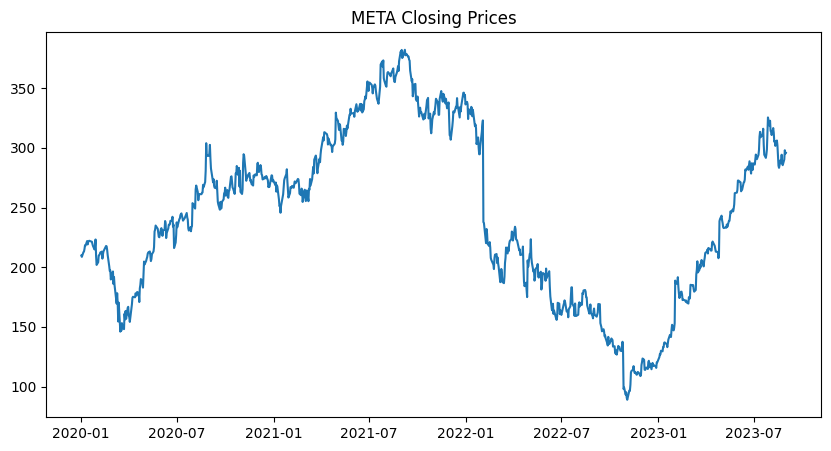

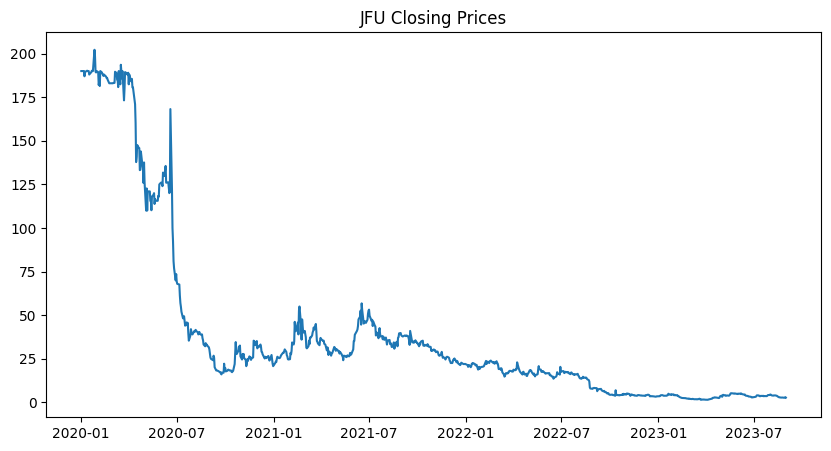

In [ ]:
# Plot closing prices over time
for symbol in symbols:
    plt.figure(figsize=(10, 5))
    plt.plot(data['Close'][symbol])
    plt.title(symbol + ' Closing Prices')
    plt.show()

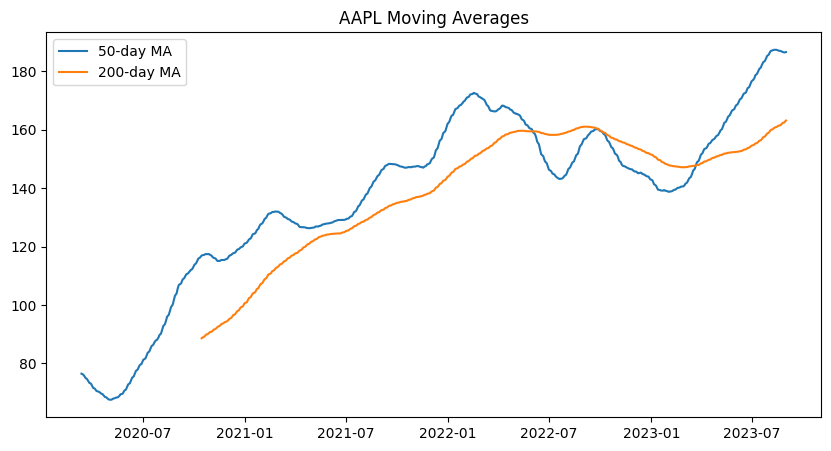

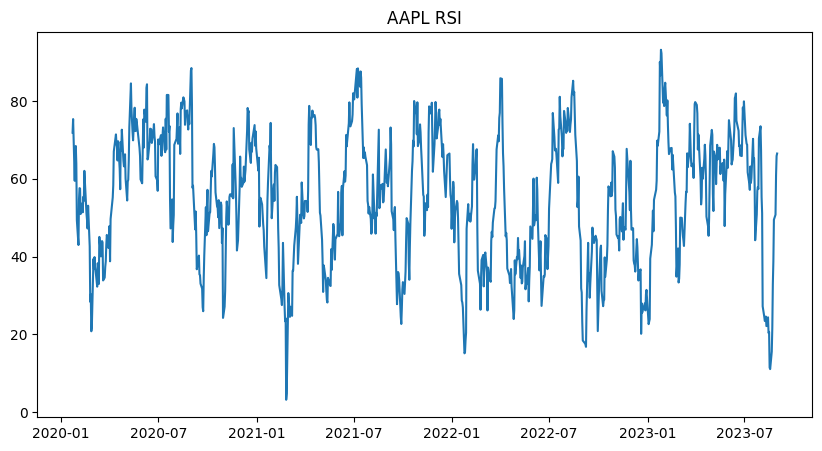

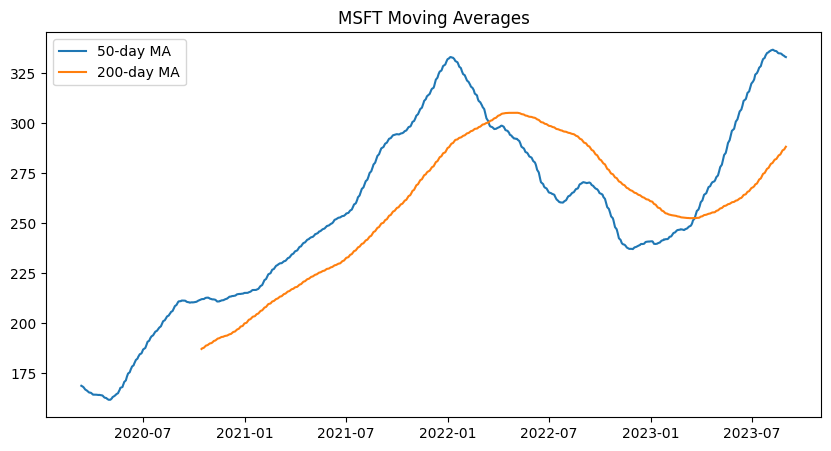

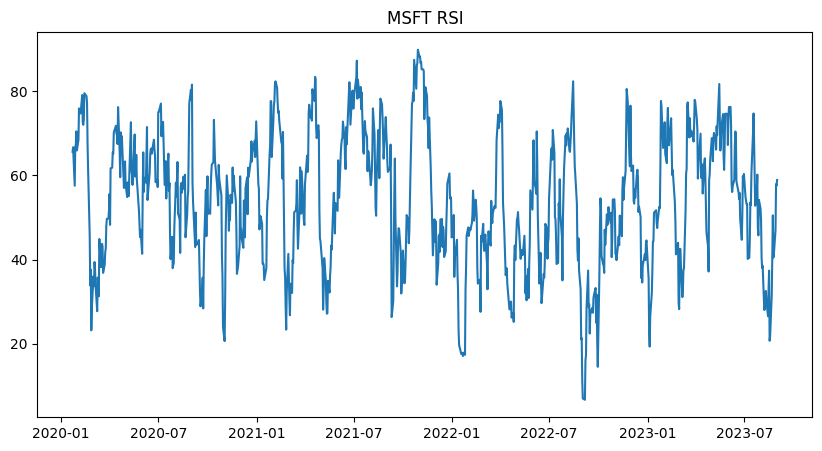

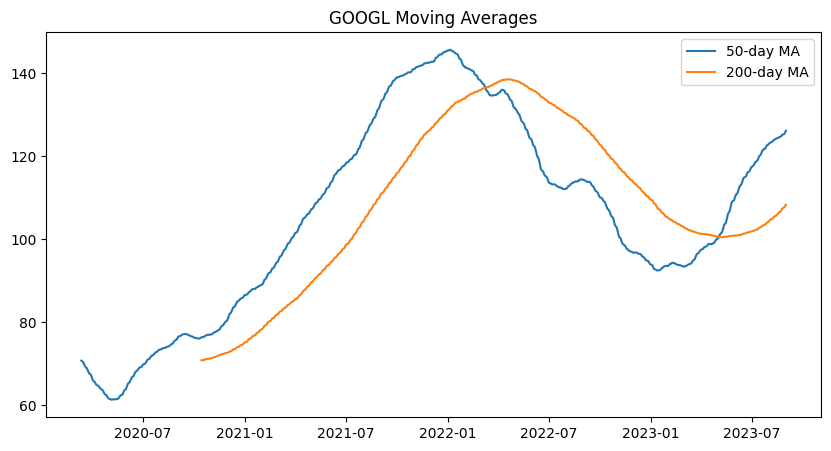

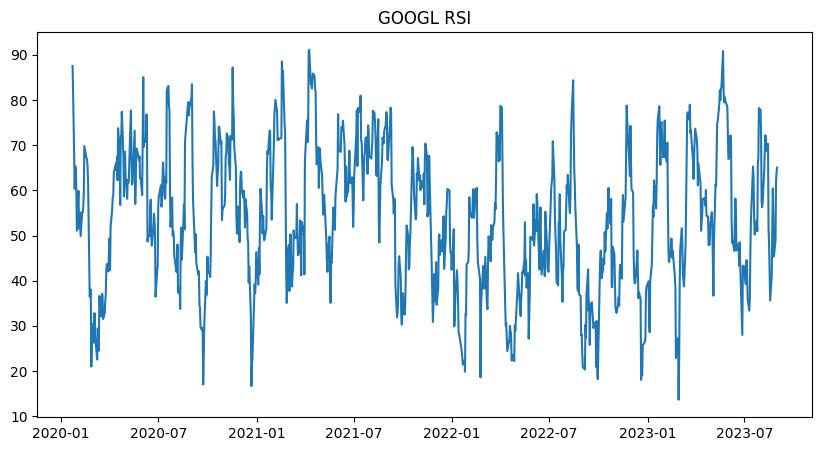

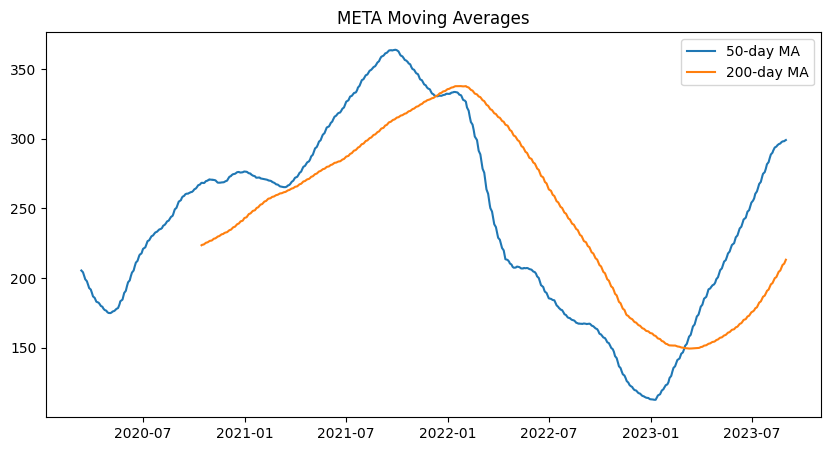

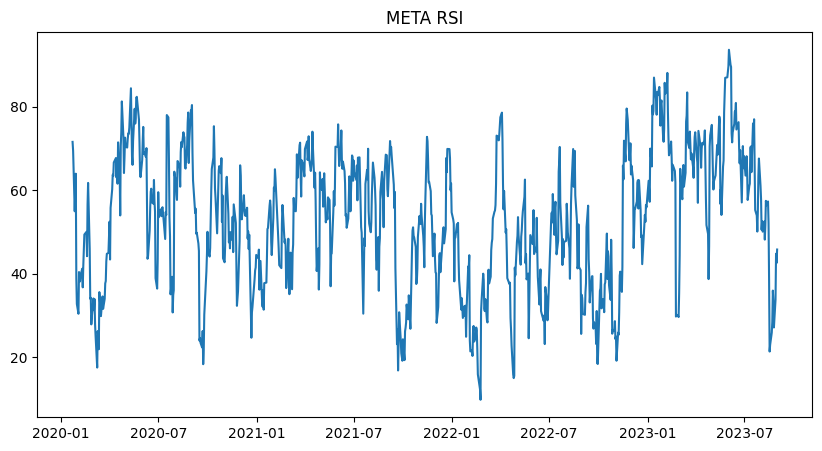

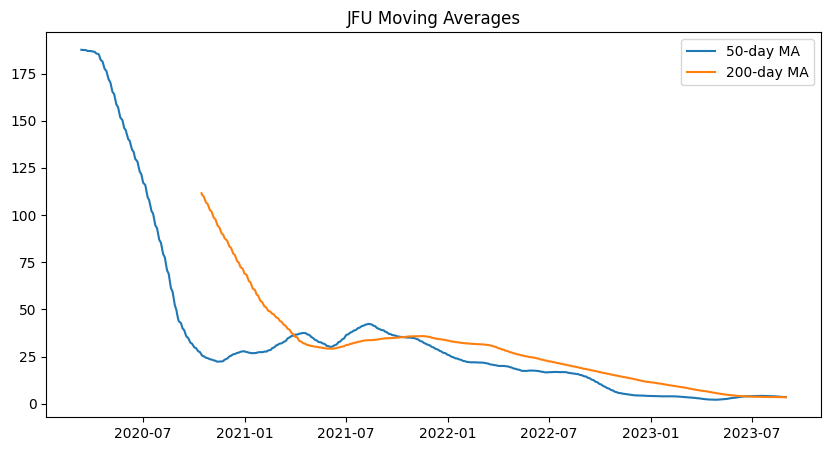

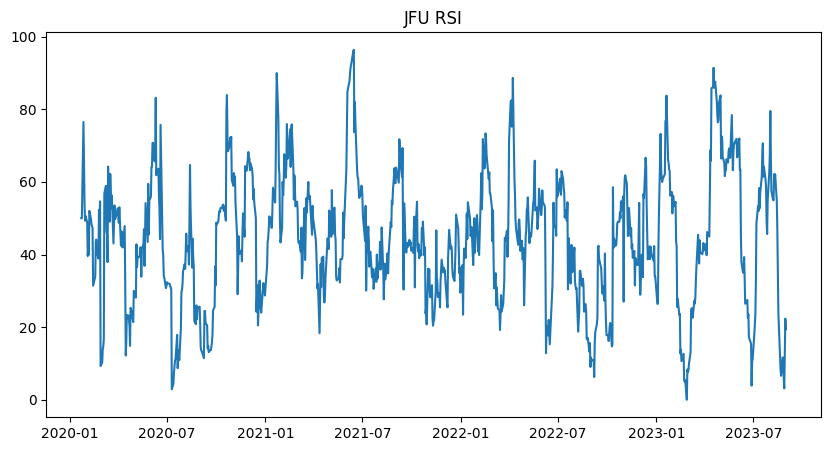

In [ ]:
# Plot moving averages and RSI over time
for symbol in symbols:
    plt.figure(figsize=(10, 5))
    plt.plot(data[symbol+'_MA50'], label='50-day MA')
    plt.plot(data[symbol+'_MA200'], label='200-day MA')
    plt.title(symbol + ' Moving Averages')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(data[symbol+'_RSI'])
    plt.title(symbol + ' RSI')
    plt.show()


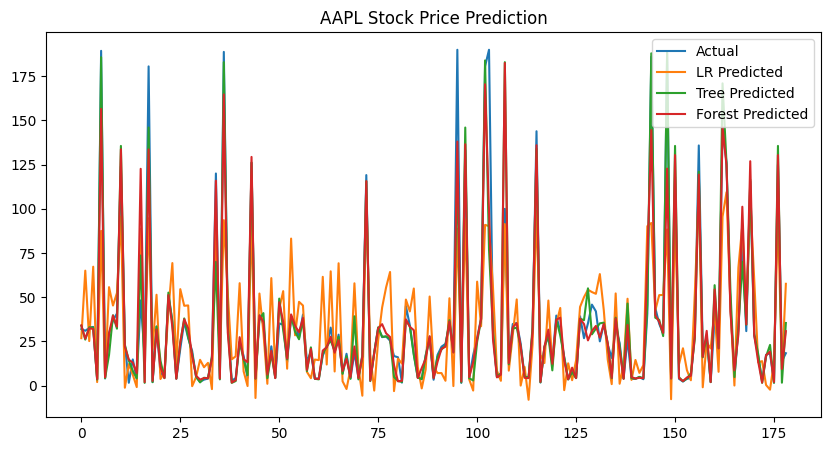

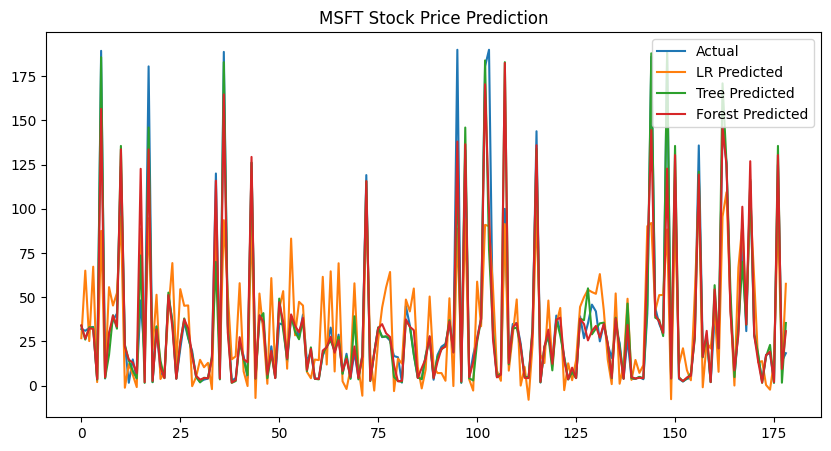

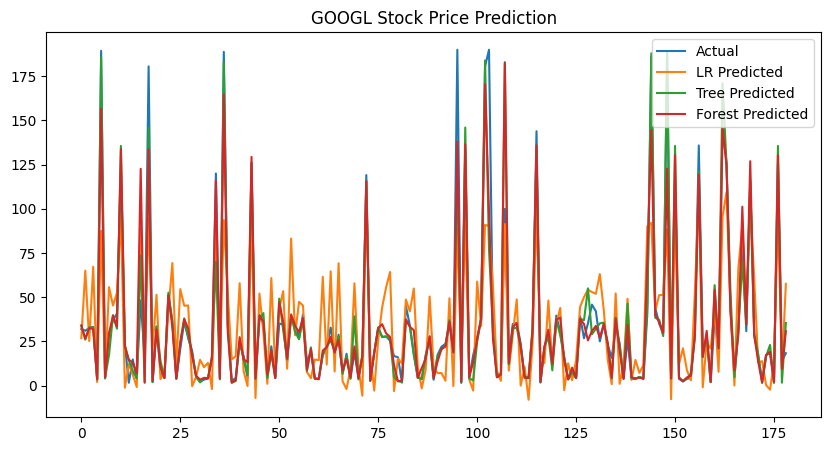

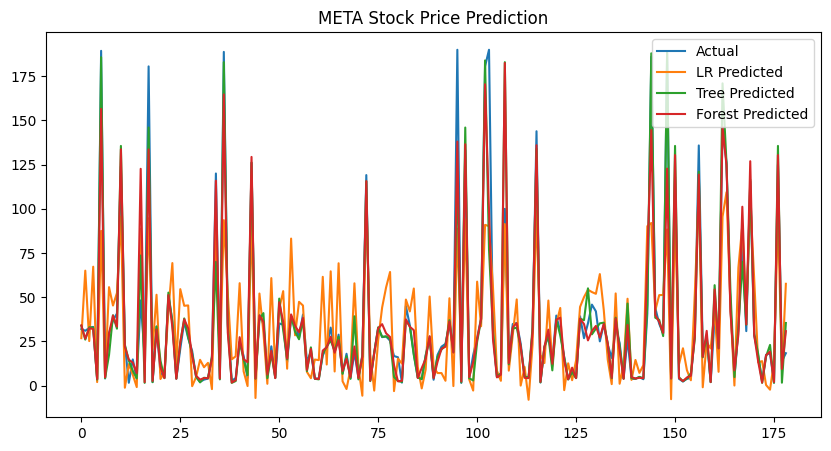

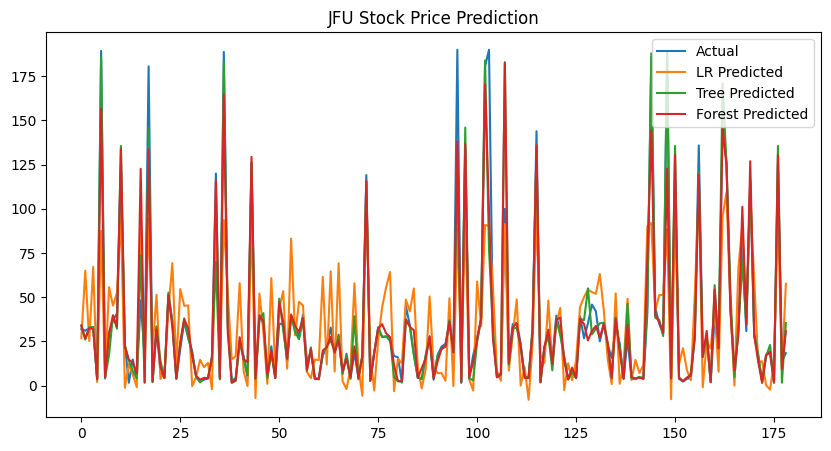

In [ ]:
# Compare actual vs predicted prices
for symbol in symbols:
    lr_pred = lr.predict(x_test_pca)
    tree_pred = tree.predict(x_test_pca)
    forest_pred = forest.predict(x_test_pca)

    plt.figure(figsize=(10, 5))
    plt.plot(y_test, label='Actual')
    plt.plot(lr_pred, label='LR Predicted')
    plt.plot(tree_pred, label='Tree Predicted')
    plt.plot(forest_pred, label='Forest Predicted')
    plt.title(symbol + ' Stock Price Prediction')
    plt.legend()
    plt.show()